# Model

In [1]:
%load_ext autoreload
%autoreload 2

import os

In [2]:
path_list = os.getcwd().split('\\')
if path_list[-1] == 'src':
    print(os.getcwd())
else:
    os.chdir('..')
    print(os.getcwd())

F:\study\Hackatons\DashboardSber\src


In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)

from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import HDBSCAN, Birch, BisectingKMeans, KMeans, MeanShift
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Загрузка данных

In [4]:
def fix_date_columns(df):
    new_columns = [df.columns[0]]
    for column in df.columns[1:]:
        date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(column) - 2).strftime('%Y-%m-%d')
        new_columns.append(date)

    df.columns = new_columns
    return df


df_acquiring = pd.read_excel(
    io='dataset/acquiring.xlsb',
    engine='pyxlsb',
    header=1,  # У файла есть заголовок-объединение
    # nrows=1000,
)
df_acquiring = fix_date_columns(df_acquiring)

# df_rko = pd.read_excel(
#     io='dataset/rko.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )
# df_rko = fix_date_columns(df_rko)

# df_economy_acquiring = pd.read_excel(
#     io='dataset/economy_acquiring.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_economy_general = pd.read_excel(
#     io='dataset/economy_general.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

df_general = pd.read_excel(
    io='dataset/general.xlsb',
    engine='pyxlsb',
    header=0,  # У файла есть заголовок-объединение
)
df_general['Кластер'] = df_general['Кластер'].astype('category')
df_general = df_general.drop(['ОКВЭД, основная деятельность', 'ОКВЭД, дополнительные', 'Наименование основного ОКВЭД'], axis=1)
df_general

,клиент,Сегмент id,Кластер,Средний возраст работников,Тип организации,bank_1,bank_2,bank_3,bank_4,bank_5,bank_6,bank_7,bank_8,bank_9,bank_10,bank_11,bank_12,bank_13,bank_14,bank_15,bank_16,bank_17,bank_18,bank_19,bank_20,bank_21,bank_22,bank_23,bank_24,bank_25,bank_26,bank_27,bank_28,bank_29,bank_30,bank_31,bank_32,bank_33,bank_34,bank_35,bank_36,bank_37,bank_38,bank_39,bank_40,bank_41,bank_42,bank_43,bank_44,bank_45,bank_46,bank_47,bank_48,bank_49,bank_50,ns_promotion,acquiring_mobile,acreditiv,arenda_seyf,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,broker,capital_markets,cash_management,dbo,dcd,deposit_sertificat,einvoicing,eko_docdoc,eko_interkomp,eko_korus,eko_sbermobile,eko_segmento,eko_tot,factoring,garantee_gos,garantee_kontract,garantee_other,invest_kredit,itog_bank,itog_eko,kbk,konversion,mb_a,ns_bukh,ns_business,ns_document,ns_in_app,nso,ns_priem_plat,ns_servis,ns_terminal,ns_torg,oborot_kredit,obsluzh_rts_rur,obsluzh_rts_val,overdraft_kredit,pfi,products_lizing,proekt_finans,spec_acc,us,veksel,bank_guarantees,credit,corporate_cards,valuta_control,deposit,inkass,acquiring_torg,rko,zarplat_projects,samoinkass,Компания в стадии ликвидации
0,client_5139,0,2,[40-48),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,client_16112,0,5,[0-27),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,client_21152,0,5,[34-40),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,client_15302,0,1,[40-48),ИП,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
4,client_30885,0,6,>=48,ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48418,client_21483,0,1,[27-34),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48419,client_40397,0,1,[27-34),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
48420,client_4588,0,10,[40-48),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48421,client_17159,0,1,>=48,ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [5]:
df_acquiring.head(3)

,клиент,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,client_37877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
1,client_30115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
2,client_9554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Расчёт двух формул

In [6]:
def customer_churn_share(df: pd.DataFrame, end_id_month: int) -> float:
    """Доля оттока клиентов."""
    have_clients = df.iloc[:, end_id_month - 1]
    have_clients = have_clients[have_clients == 1]

    not_have_clients = df.iloc[have_clients.index, end_id_month]
    not_have_clients = not_have_clients[not_have_clients == 0]

    value = not_have_clients.shape[0] / have_clients.shape[0] * 100
    return value


customer_churn_share(df_acquiring, 2)

3.225806451612903

In [7]:
def customer_survival_rate(df: pd.DataFrame, end_id_month: int) -> float:
    """Расчет процента выживаемости клиентов"""
    start_clients = df.iloc[:, end_id_month - 1]
    start_clients = start_clients[start_clients == 1]

    left_clients = df.iloc[start_clients.index, end_id_month]
    left_clients = left_clients[left_clients == 0]

    df_copy = df.copy()
    df_copy = df_copy.drop(start_clients.index, axis=0)
    new_clients = df_copy.iloc[:, end_id_month]
    new_clients = new_clients[new_clients == 1]

    end_clients = start_clients.shape[0] - left_clients.shape[0] + new_clients.shape[0]
    value = ((end_clients - new_clients.shape[0]) / start_clients.shape[0]) * 100
    return value


customer_survival_rate(df_acquiring, 2)

96.7741935483871

# Feature Engineering

In [8]:
import pickle


def save_model(model: Prophet, filename: str) -> None:
    """Сохранение модели."""
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

### Создание 3 таргетов

In [9]:
series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values
level_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")].values

In [10]:
lst_customer_churn_share = [customer_churn_share(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_churn_share)

23

In [11]:
lst_customer_survival_rate = [customer_survival_rate(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_survival_rate)

23

In [17]:
df_cr_pr = pd.DataFrame(series_cols[1:], columns=["ds"])
df_cr_pr['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df_cr_pr.loc[:, "cr"] = lst_customer_churn_share
df_cr_pr.loc[:, "pr"] = lst_customer_survival_rate

df_cr_pr.loc[df_cr_pr.cr > 3, 'cr'] = df_cr_pr.cr.mean()
df_cr_pr.loc[df_cr_pr.pr < 88, 'pr'] = df_cr_pr.pr.mean()
df_cr_pr.head()

,ds,cr,pr
0,2021-10-31,2.221678,96.774194
1,2021-11-30,1.104972,98.895028
2,2021-12-31,1.104972,98.895028
3,2022-01-31,1.648352,98.351648
4,2022-02-28,1.111111,98.888889


# Модели

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def metrics(y_true, y_pred):

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f'{rmse = }')

    mae = mean_absolute_error(y_true, y_pred)
    print(f'{mae = }')

    r2 = r2_score(y_true, y_pred)
    print(f'{r2 = }')

In [50]:
# Про prophet:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

In [51]:
# Много моделей prophet с features:
# https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

In [13]:
TRAIN_END = -7

In [31]:
timeseries = df_cr_pr.cr
# timeseries = df_cr_pr.pr
# timeseries = df_acquiring[series_cols].sum().values

len(timeseries)

23

In [32]:
train_timeseries = timeseries[0:TRAIN_END]
eval_timeseries = timeseries[TRAIN_END::]
print(len(train_timeseries), len(eval_timeseries))

days = np.arange(1, len(train_timeseries) + len(eval_timeseries) + 1)
len(days)

16 7


23

In [33]:
df = pd.DataFrame(series_cols[len(series_cols) - len(days):], columns=["ds"])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.loc[:, "y"] = timeseries

# df.loc[:, "cap"] = df.y.max()
# df.loc[:, "floor"] = df.y.min()
df.loc[:, "cap"] = 100
df.loc[:, "floor"] = 0

print(df.shape)
df.tail()

(23, 4)


,ds,y,cap,floor
18,2023-05-31,1.136179,100,0
19,2023-06-30,0.684053,100,0
20,2023-07-31,0.534896,100,0
21,2023-08-31,1.107670,100,0
22,2023-09-30,1.268946,100,0


In [34]:
# df[['ds', 'y']].to_csv('data_cr_eq.csv', index=False)

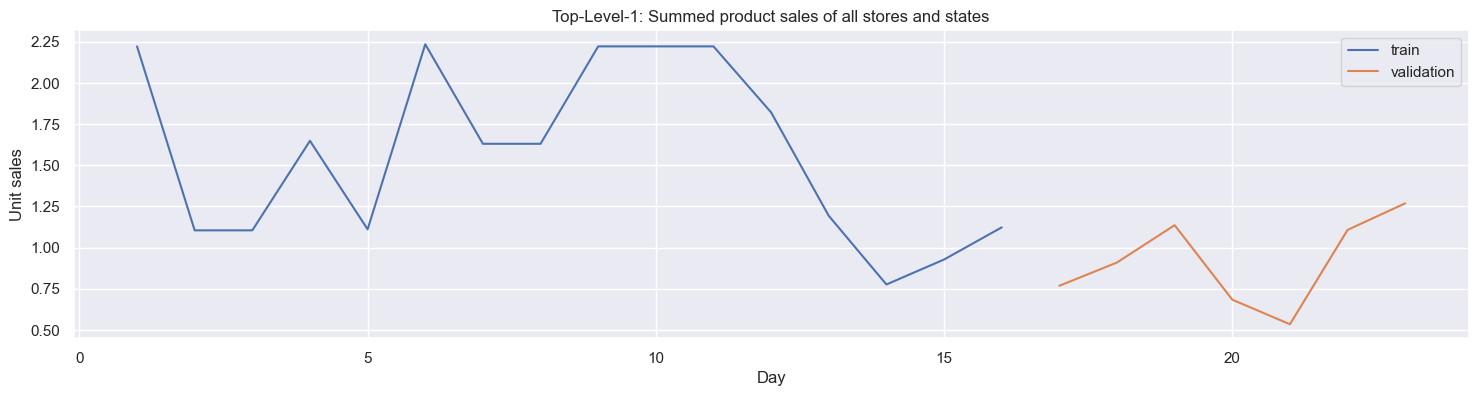

In [35]:
plt.figure(figsize=(18, 4))
plt.plot(days[0:TRAIN_END], train_timeseries, label="train")
plt.plot(days[TRAIN_END::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [36]:
train_df = df.iloc[0:TRAIN_END]
print(train_df.shape)

eval_df = df.iloc[TRAIN_END::]
print(eval_df.shape)

(16, 4)
(7, 4)


In [38]:
import optuna


def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float("changepoint_prior_scale", 0.0001, 3.0),
        "seasonality_prior_scale": trial.suggest_int("seasonality_prior_scale", 1, 20),
        'growth':  trial.suggest_categorical("growth", ["logistic", "linear"]),
        "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        # 'yearly_seasonality': trial.suggest_categorical("yearly_seasonality", [True, False]),
        # 'weekly_seasonality': trial.suggest_categorical("weekly_seasonality", [True, False]),
        'interval_width': trial.suggest_float("interval_width", 0.75, 0.95),
    }

    model = Prophet(**params)
    model.add_country_holidays('Russia')
    model.fit(train_df)

    pred = model.predict(eval_df)
    pred.index = eval_df.index

    rmse = mean_squared_error(pred.yhat, eval_df.y, squared=False)
    metrics(pred.yhat, eval_df.y)
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-19 17:24:18,372] A new study created in memory with name: no-name-4f2f3c17-597d-4054-9450-3cdaa1fe1297
17:24:18 - cmdstanpy - INFO - Chain [1] start processing
17:24:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:18,972] Trial 0 finished with value: 1.2589259061811031 and parameters: {'changepoint_prior_scale': 2.7297786854184016, 'seasonality_prior_scale': 11, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.8561633560987947}. Best is trial 0 with value: 1.2589259061811031.


rmse = 1.2589259061811031
mae = 1.1001263894663216
r2 = -6.044526626102295


17:24:19 - cmdstanpy - INFO - Chain [1] start processing
17:24:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:19,946] Trial 1 finished with value: 0.6259553200090995 and parameters: {'changepoint_prior_scale': 2.8718121840985127, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.9136317550386253}. Best is trial 1 with value: 0.6259553200090995.


rmse = 0.6259553200090995
mae = 0.5336435793680193
r2 = -16.49426894684001


17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:20,542] Trial 2 finished with value: 1.2606072863231346 and parameters: {'changepoint_prior_scale': 2.9222239164901587, 'seasonality_prior_scale': 11, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.9139252972378653}. Best is trial 1 with value: 0.6259553200090995.


rmse = 1.2606072863231346
mae = 1.101866775805367
r2 = -6.052765301596543


17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:21,108] Trial 3 finished with value: 0.43109077435084336 and parameters: {'changepoint_prior_scale': 0.23917670688938988, 'seasonality_prior_scale': 11, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.9078584643490583}. Best is trial 3 with value: 0.43109077435084336.


rmse = 0.43109077435084336
mae = 0.36275938585611606
r2 = -55.737054843000394


17:24:21 - cmdstanpy - INFO - Chain [1] start processing
17:24:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:21,676] Trial 4 finished with value: 0.6410365074431548 and parameters: {'changepoint_prior_scale': 0.4651361012438984, 'seasonality_prior_scale': 6, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8631162121729746}. Best is trial 3 with value: 0.43109077435084336.


rmse = 0.6410365074431548
mae = 0.49546445493690994
r2 = -4.110073945215263


17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:22,337] Trial 5 finished with value: 1.2309737174592783 and parameters: {'changepoint_prior_scale': 2.0513984295446814, 'seasonality_prior_scale': 18, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.911726802894014}. Best is trial 3 with value: 0.43109077435084336.


rmse = 1.2309737174592783
mae = 1.072385016970275
r2 = -5.976769817482522


17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:22,926] Trial 6 finished with value: 0.30590672060490715 and parameters: {'changepoint_prior_scale': 0.24350761687482567, 'seasonality_prior_scale': 8, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8402232108508481}. Best is trial 6 with value: 0.30590672060490715.


rmse = 0.30590672060490715
mae = 0.2768343824830249
r2 = -16.683450383251383


17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:23,815] Trial 7 finished with value: 0.6006348634413972 and parameters: {'changepoint_prior_scale': 1.9225754625091267, 'seasonality_prior_scale': 10, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7963366033757548}. Best is trial 6 with value: 0.30590672060490715.


rmse = 0.6006348634413972
mae = 0.5021167112483018
r2 = -14.491821621810756


17:24:24 - cmdstanpy - INFO - Chain [1] start processing
17:24:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:24,592] Trial 8 finished with value: 0.5233768728040433 and parameters: {'changepoint_prior_scale': 1.046592587682533, 'seasonality_prior_scale': 20, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.9213986905153599}. Best is trial 6 with value: 0.30590672060490715.


rmse = 0.5233768728040433
mae = 0.4054991505215716
r2 = -10.118714292410036


17:24:24 - cmdstanpy - INFO - Chain [1] start processing
17:24:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:25,167] Trial 9 finished with value: 1.2337108701856856 and parameters: {'changepoint_prior_scale': 2.0889041014005545, 'seasonality_prior_scale': 20, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.9296318493224051}. Best is trial 6 with value: 0.30590672060490715.


rmse = 1.2337108701856856
mae = 1.0750905318130612
r2 = -5.982730284220827


17:24:25 - cmdstanpy - INFO - Chain [1] start processing
17:24:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:25,817] Trial 10 finished with value: 0.304079081209444 and parameters: {'changepoint_prior_scale': 0.03875333407852488, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7775286576927587}. Best is trial 10 with value: 0.304079081209444.


rmse = 0.304079081209444
mae = 0.276358592000546
r2 = -16.181867125842118


17:24:26 - cmdstanpy - INFO - Chain [1] start processing
17:24:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:26,440] Trial 11 finished with value: 0.30352561896084 and parameters: {'changepoint_prior_scale': 0.08588002807319059, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7529104198847117}. Best is trial 11 with value: 0.30352561896084.


rmse = 0.30352561896084
mae = 0.276220504127687
r2 = -16.015085531880118


17:24:26 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:27,194] Trial 12 finished with value: 0.4230906017146384 and parameters: {'changepoint_prior_scale': 0.7816826101541412, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7534419284687979}. Best is trial 11 with value: 0.30352561896084.


rmse = 0.4230906017146384
mae = 0.30956655265223343
r2 = -6.730791799610283


17:24:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:27,852] Trial 13 finished with value: 0.2924716700731696 and parameters: {'changepoint_prior_scale': 0.003138517327243587, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7515751193836044}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.2924716700731696
mae = 0.2721807238126703
r2 = -12.821450719662165


17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:28,536] Trial 14 finished with value: 0.30277824025800104 and parameters: {'changepoint_prior_scale': 0.027050403329384118, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7531368203959922}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.30277824025800104
mae = 0.276012671025384
r2 = -15.811912793669144


17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:29,295] Trial 15 finished with value: 0.4804190062694116 and parameters: {'changepoint_prior_scale': 0.8727591098702645, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7893859433402483}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.4804190062694116
mae = 0.3631040528125023
r2 = -8.432062142700442


17:24:29 - cmdstanpy - INFO - Chain [1] start processing
17:24:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:29,946] Trial 16 finished with value: 0.3806832352692858 and parameters: {'changepoint_prior_scale': 0.4527474401898624, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8026234505102603}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3806832352692858
mae = 0.31355574562058575
r2 = -41.993777005013236


17:24:30 - cmdstanpy - INFO - Chain [1] start processing
17:24:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:30,850] Trial 17 finished with value: 0.5422970433639132 and parameters: {'changepoint_prior_scale': 1.16144514387028, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7515637952402118}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.5422970433639132
mae = 0.4278558449471809
r2 = -11.003134274592272


17:24:31 - cmdstanpy - INFO - Chain [1] start processing
17:24:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:31,685] Trial 18 finished with value: 0.37459640676224687 and parameters: {'changepoint_prior_scale': 0.42737395839150755, 'seasonality_prior_scale': 7, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7714584473938364}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.37459640676224687
mae = 0.30721595753120173
r2 = -39.144724569200875


17:24:32 - cmdstanpy - INFO - Chain [1] start processing
17:24:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:32,533] Trial 19 finished with value: 0.3979413297876734 and parameters: {'changepoint_prior_scale': 0.5440796800803598, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8203677876847683}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3979413297876734
mae = 0.3308068119781886
r2 = -51.259166315775296


17:24:32 - cmdstanpy - INFO - Chain [1] start processing
17:24:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:33,386] Trial 20 finished with value: 0.5704610543306148 and parameters: {'changepoint_prior_scale': 1.4142641827007976, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7740657847655311}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.5704610543306148
mae = 0.46402458018875326
r2 = -12.521844217762805


17:24:33 - cmdstanpy - INFO - Chain [1] start processing
17:24:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:33,938] Trial 21 finished with value: 0.30417872293245335 and parameters: {'changepoint_prior_scale': 0.08783549534317958, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7524491649570629}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.30417872293245335
mae = 0.2763866594451583
r2 = -16.20731862505423


17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:34,499] Trial 22 finished with value: 0.3013141009777067 and parameters: {'changepoint_prior_scale': 0.029296007162069003, 'seasonality_prior_scale': 2, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.766882340248781}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3013141009777067
mae = 0.27557142234147963
r2 = -15.436125070936598


17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:35,032] Trial 23 finished with value: 0.3002684067227852 and parameters: {'changepoint_prior_scale': 0.02031112792756571, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7688432291557697}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3002684067227852
mae = 0.2752545839104754
r2 = -15.148846413879863


17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:35,638] Trial 24 finished with value: 0.34319051477078105 and parameters: {'changepoint_prior_scale': 0.6495886715863004, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7768001877238782}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.34319051477078105
mae = 0.2787435026025077
r2 = -5.270253415809936


17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:36,248] Trial 25 finished with value: 0.33595630439511265 and parameters: {'changepoint_prior_scale': 0.3052084407549522, 'seasonality_prior_scale': 6, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8079932050992817}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.33595630439511265
mae = 0.2832277733140581
r2 = -24.669178275419178


17:24:36 - cmdstanpy - INFO - Chain [1] start processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:36,842] Trial 26 finished with value: 0.34819659643162937 and parameters: {'changepoint_prior_scale': 0.6228963686232827, 'seasonality_prior_scale': 2, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7881496716322205}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.34819659643162937
mae = 0.2783542201176651
r2 = -5.263841417326849


17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:37,542] Trial 27 finished with value: 0.30438605987869977 and parameters: {'changepoint_prior_scale': 0.04022316435324124, 'seasonality_prior_scale': 9, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7698419587934971}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.30438605987869977
mae = 0.2764510310967398
r2 = -16.25209565996566


17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:38,183] Trial 28 finished with value: 0.3424521711176165 and parameters: {'changepoint_prior_scale': 0.322507262934426, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8123821950969194}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3424521711176165
mae = 0.28708626621837813
r2 = -26.74765601545135


17:24:38 - cmdstanpy - INFO - Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:39,048] Trial 29 finished with value: 0.8549868339902302 and parameters: {'changepoint_prior_scale': 0.7491058469815183, 'seasonality_prior_scale': 6, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7920625941047233}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.8549868339902302
mae = 0.6949763218120226
r2 = -5.007250150942951


17:24:39 - cmdstanpy - INFO - Chain [1] start processing
17:24:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:39,613] Trial 30 finished with value: 0.3134680229124907 and parameters: {'changepoint_prior_scale': 0.25559651878677764, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7672926863208548}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3134680229124907
mae = 0.27876095070674684
r2 = -18.53736708743968


17:24:39 - cmdstanpy - INFO - Chain [1] start processing
17:24:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:40,187] Trial 31 finished with value: 0.30525800683507126 and parameters: {'changepoint_prior_scale': 0.12290582837397063, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7639399033984928}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.30525800683507126
mae = 0.276662324288018
r2 = -16.513421040829215


17:24:40 - cmdstanpy - INFO - Chain [1] start processing
17:24:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:40,759] Trial 32 finished with value: 0.3012619114552219 and parameters: {'changepoint_prior_scale': 0.028953283591253928, 'seasonality_prior_scale': 5, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7624846201082977}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3012619114552219
mae = 0.2755572253336136
r2 = -15.420115886853797


17:24:41 - cmdstanpy - INFO - Chain [1] start processing
17:24:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:41,386] Trial 33 finished with value: 0.3748698983186443 and parameters: {'changepoint_prior_scale': 0.431376356478958, 'seasonality_prior_scale': 5, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7628428087075904}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3748698983186443
mae = 0.3075041029774984
r2 = -39.27887615342493


17:24:41 - cmdstanpy - INFO - Chain [1] start processing
17:24:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:41,950] Trial 34 finished with value: 0.3056717624896542 and parameters: {'changepoint_prior_scale': 0.23092491139773158, 'seasonality_prior_scale': 2, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7853763186040523}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3056717624896542
mae = 0.2768617564693687
r2 = -16.504436413229712


17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:42,467] Trial 35 finished with value: 0.46047156780176585 and parameters: {'changepoint_prior_scale': 0.0005072891050480837, 'seasonality_prior_scale': 2, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7826632165328231}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.46047156780176585
mae = 0.3880979872297229
r2 = -89.88178323324082


17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:43,024] Trial 36 finished with value: 0.35326362505831194 and parameters: {'changepoint_prior_scale': 0.35117564732560735, 'seasonality_prior_scale': 5, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7646245543180348}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.35326362505831194
mae = 0.2940302326600096
r2 = -30.438000855156886


17:24:43 - cmdstanpy - INFO - Chain [1] start processing
17:24:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:43,572] Trial 37 finished with value: 0.7503076409874386 and parameters: {'changepoint_prior_scale': 0.5720571763127006, 'seasonality_prior_scale': 8, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7795140878696462}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.7503076409874386
mae = 0.5952572175299203
r2 = -4.585097156447489


17:24:43 - cmdstanpy - INFO - Chain [1] start processing
17:24:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:44,139] Trial 38 finished with value: 0.305209318795952 and parameters: {'changepoint_prior_scale': 0.21866107679231644, 'seasonality_prior_scale': 5, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7961882826598697}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.305209318795952
mae = 0.2766184179631238
r2 = -16.54137163826909


17:24:44 - cmdstanpy - INFO - Chain [1] start processing
17:24:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:44,753] Trial 39 finished with value: 0.43019640980127705 and parameters: {'changepoint_prior_scale': 0.18023137091103214, 'seasonality_prior_scale': 2, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.8235560673418164}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.43019640980127705
mae = 0.36192376799481696
r2 = -55.619963179967456


17:24:45 - cmdstanpy - INFO - Chain [1] start processing
17:24:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:45,544] Trial 40 finished with value: 0.37738674503726494 and parameters: {'changepoint_prior_scale': 0.4378626485612244, 'seasonality_prior_scale': 7, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7617440829756315}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.37738674503726494
mae = 0.3101407612284993
r2 = -40.445777070198375


17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:46,528] Trial 41 finished with value: 0.29676498701164866 and parameters: {'changepoint_prior_scale': 0.007343076444906801, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7502742424272673}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.29676498701164866
mae = 0.27399094591589074
r2 = -14.280285301393182


17:24:47 - cmdstanpy - INFO - Chain [1] start processing
17:24:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:47,517] Trial 42 finished with value: 0.30522627916612655 and parameters: {'changepoint_prior_scale': 0.1737355834293356, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7642192810795143}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.30522627916612655
mae = 0.2766596700449871
r2 = -16.49741491443761


17:24:48 - cmdstanpy - INFO - Chain [1] start processing
17:24:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:49,350] Trial 43 finished with value: 0.32376071679693563 and parameters: {'changepoint_prior_scale': 0.2780516817768774, 'seasonality_prior_scale': 2, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7768410339150613}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.32376071679693563
mae = 0.2809709742462502
r2 = -21.214928923844877


17:24:50 - cmdstanpy - INFO - Chain [1] start processing
17:24:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:50,478] Trial 44 finished with value: 0.3050306252324981 and parameters: {'changepoint_prior_scale': 0.10895062287306083, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7501002419397365}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3050306252324981
mae = 0.2766084045702315
r2 = -16.444452171915554


17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:51,861] Trial 45 finished with value: 0.3028000092076942 and parameters: {'changepoint_prior_scale': 0.032209872013036024, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7590845636929621}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3028000092076942
mae = 0.276019702736909
r2 = -15.816653825248437


17:24:52 - cmdstanpy - INFO - Chain [1] start processing
17:24:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:52,871] Trial 46 finished with value: 0.35108438535753816 and parameters: {'changepoint_prior_scale': 0.3457379164033968, 'seasonality_prior_scale': 5, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7722439830536337}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.35108438535753816
mae = 0.2926605086557806
r2 = -29.68766272173671


17:24:53 - cmdstanpy - INFO - Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:53,682] Trial 47 finished with value: 0.2970352270642325 and parameters: {'changepoint_prior_scale': 0.006896652915816162, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7843674786236944}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.2970352270642325
mae = 0.2740935203956229
r2 = -14.352536201419518


17:24:54 - cmdstanpy - INFO - Chain [1] start processing
17:24:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:54,223] Trial 48 finished with value: 0.4315658852907316 and parameters: {'changepoint_prior_scale': 0.17312696032664254, 'seasonality_prior_scale': 12, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7838546134162723}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.4315658852907316
mae = 0.36317469869943314
r2 = -56.32961775562697


17:24:54 - cmdstanpy - INFO - Chain [1] start processing
17:24:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:54,814] Trial 49 finished with value: 0.3945401672661902 and parameters: {'changepoint_prior_scale': 0.5248676247165367, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7588691851419888}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3945401672661902
mae = 0.3274806323071301
r2 = -49.36147197798224


17:24:55 - cmdstanpy - INFO - Chain [1] start processing
17:24:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:55,575] Trial 50 finished with value: 0.3492897749147615 and parameters: {'changepoint_prior_scale': 0.3403820056122087, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7947440896374429}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3492897749147615
mae = 0.2915358615660408
r2 = -29.03863517703868


17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:56,412] Trial 51 finished with value: 0.30111304983682496 and parameters: {'changepoint_prior_scale': 0.029434273250170288, 'seasonality_prior_scale': 2, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7715442804444217}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.30111304983682496
mae = 0.27551411299314105
r2 = -15.37763717394273


17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:57,088] Trial 52 finished with value: 0.3054586671336019 and parameters: {'changepoint_prior_scale': 0.15195763322268993, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7576842135567077}. Best is trial 13 with value: 0.2924716700731696.


rmse = 0.3054586671336019
mae = 0.27670481406356057
r2 = -16.580597582559466


17:24:57 - cmdstanpy - INFO - Chain [1] start processing
17:24:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:58,749] Trial 53 finished with value: 0.2856401148943795 and parameters: {'changepoint_prior_scale': 0.0008699713288688703, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7752938136326595}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2856401148943795
mae = 0.26291832128101167
r2 = -12.352101423928


17:24:59 - cmdstanpy - INFO - Chain [1] start processing
17:24:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:59,324] Trial 54 finished with value: 0.30583364384477835 and parameters: {'changepoint_prior_scale': 0.1666507032013222, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7751709720375776}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30583364384477835
mae = 0.2768309167736594
r2 = -16.643494880738768


17:24:59 - cmdstanpy - INFO - Chain [1] start processing
17:24:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:24:59,958] Trial 55 finished with value: 0.3725443492845248 and parameters: {'changepoint_prior_scale': 0.41804412149051484, 'seasonality_prior_scale': 2, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7507536913938821}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3725443492845248
mae = 0.30531772804438845
r2 = -38.224984578798775


17:25:00 - cmdstanpy - INFO - Chain [1] start processing
17:25:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:00,636] Trial 56 finished with value: 0.2941186845638401 and parameters: {'changepoint_prior_scale': 0.006258898817581668, 'seasonality_prior_scale': 18, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7803440667111878}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2941186845638401
mae = 0.2729375709742993
r2 = -13.46484943263211


17:25:00 - cmdstanpy - INFO - Chain [1] start processing
17:25:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:01,267] Trial 57 finished with value: 0.3054733808103549 and parameters: {'changepoint_prior_scale': 0.23847385192647103, 'seasonality_prior_scale': 18, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7813019547869124}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3054733808103549
mae = 0.2767509385841382
r2 = -16.52885337505933


17:25:01 - cmdstanpy - INFO - Chain [1] start processing
17:25:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:01,863] Trial 58 finished with value: 0.3892772326851807 and parameters: {'changepoint_prior_scale': 0.5090207542111713, 'seasonality_prior_scale': 18, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.789351558460822}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3892772326851807
mae = 0.3222387208773037
r2 = -47.78260923241638


17:25:02 - cmdstanpy - INFO - Chain [1] start processing
17:25:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:02,464] Trial 59 finished with value: 0.3053418845198478 and parameters: {'changepoint_prior_scale': 0.1297532707355186, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8019178510749162}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3053418845198478
mae = 0.2766795172455419
r2 = -16.54229381747766


17:25:02 - cmdstanpy - INFO - Chain [1] start processing
17:25:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:03,137] Trial 60 finished with value: 0.2970696628719333 and parameters: {'changepoint_prior_scale': 0.00727703258714169, 'seasonality_prior_scale': 19, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7712278319698627}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2970696628719333
mae = 0.2741034774845242
r2 = -14.365874335421317


17:25:03 - cmdstanpy - INFO - Chain [1] start processing
17:25:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:03,895] Trial 61 finished with value: 0.30546623631111536 and parameters: {'changepoint_prior_scale': 0.1300378206129397, 'seasonality_prior_scale': 19, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7576569096849424}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30546623631111536
mae = 0.27671951214342866
r2 = -16.565853062689627


17:25:04 - cmdstanpy - INFO - Chain [1] start processing
17:25:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:04,442] Trial 62 finished with value: 0.30074864343955365 and parameters: {'changepoint_prior_scale': 0.01874541617906695, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7735938515323898}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30074864343955365
mae = 0.2753988829692465
r2 = -15.2847865002127


17:25:04 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:05,150] Trial 63 finished with value: 0.31617549106799153 and parameters: {'changepoint_prior_scale': 0.261227767315065, 'seasonality_prior_scale': 20, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7693638715741427}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.31617549106799153
mae = 0.279383047502805
r2 = -19.217273502947176


17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:05,721] Trial 64 finished with value: 0.3484762766911514 and parameters: {'changepoint_prior_scale': 0.3366060413225626, 'seasonality_prior_scale': 19, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7810205360637066}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3484762766911514
mae = 0.291077391472847
r2 = -28.613776924527546


17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:06,277] Trial 65 finished with value: 0.3021107796344039 and parameters: {'changepoint_prior_scale': 0.017323756201305787, 'seasonality_prior_scale': 10, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7901100306331568}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3021107796344039
mae = 0.27580657010889686
r2 = -15.65098235361506


17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:06,863] Trial 66 finished with value: 0.30465962436805794 and parameters: {'changepoint_prior_scale': 0.11049102385209877, 'seasonality_prior_scale': 19, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7676976225266195}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30465962436805794
mae = 0.27655767507781576
r2 = -16.282016325402715


17:25:07 - cmdstanpy - INFO - Chain [1] start processing
17:25:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:07,525] Trial 67 finished with value: 0.4311954311394187 and parameters: {'changepoint_prior_scale': 0.24464896066470995, 'seasonality_prior_scale': 17, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7555991918009691}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.4311954311394187
mae = 0.36284893959784886
r2 = -55.90454078462661


17:25:07 - cmdstanpy - INFO - Chain [1] start processing
17:25:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:08,080] Trial 68 finished with value: 0.3054624722396118 and parameters: {'changepoint_prior_scale': 0.13691041591712552, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7851936645961635}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3054624722396118
mae = 0.2767078481550432
r2 = -16.578927730750213


17:25:08 - cmdstanpy - INFO - Chain [1] start processing
17:25:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:08,794] Trial 69 finished with value: 0.3685229380699742 and parameters: {'changepoint_prior_scale': 0.4023261326974021, 'seasonality_prior_scale': 12, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7579737368608817}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3685229380699742
mae = 0.3030611380832796
r2 = -36.45013410806399


17:25:09 - cmdstanpy - INFO - Chain [1] start processing
17:25:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:09,379] Trial 70 finished with value: 0.29308412572533404 and parameters: {'changepoint_prior_scale': 0.004343758266826557, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7773456844080061}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29308412572533404
mae = 0.27246653390605585
r2 = -13.098244009340583


17:25:09 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:10,246] Trial 71 finished with value: 0.29253391777535864 and parameters: {'changepoint_prior_scale': 0.0031014042002190084, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.778128347616933}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29253391777535864
mae = 0.27220930504747304
r2 = -12.85414298112902


17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:10,829] Trial 72 finished with value: 0.3052798929108767 and parameters: {'changepoint_prior_scale': 0.09376177585171774, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7779892832800389}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3052798929108767
mae = 0.2766667431294162
r2 = -16.521049396236908


17:25:11 - cmdstanpy - INFO - Chain [1] start processing
17:25:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:11,402] Trial 73 finished with value: 0.30562239187752094 and parameters: {'changepoint_prior_scale': 0.2174160134797276, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7966467200284708}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30562239187752094
mae = 0.2767447544272957
r2 = -16.628183087420638


17:25:11 - cmdstanpy - INFO - Chain [1] start processing
17:25:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:11,966] Trial 74 finished with value: 0.29409199840511896 and parameters: {'changepoint_prior_scale': 0.00968111055864413, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7504386843911244}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29409199840511896
mae = 0.2729314366536602
r2 = -13.44717860589505


17:25:12 - cmdstanpy - INFO - Chain [1] start processing
17:25:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:12,571] Trial 75 finished with value: 0.3374735391361499 and parameters: {'changepoint_prior_scale': 0.3087864034574857, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7500906054692881}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3374735391361499
mae = 0.2836958369454529
r2 = -25.177519945893984


17:25:12 - cmdstanpy - INFO - Chain [1] start processing
17:25:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:13,153] Trial 76 finished with value: 0.3049648027374023 and parameters: {'changepoint_prior_scale': 0.09242048524970015, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7645027139112917}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3049648027374023
mae = 0.2766142532842946
r2 = -16.396201951704008


17:25:13 - cmdstanpy - INFO - Chain [1] start processing
17:25:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:13,737] Trial 77 finished with value: 0.30556581583385706 and parameters: {'changepoint_prior_scale': 0.1752741384613803, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.75522986210153}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30556581583385706
mae = 0.2767297648212639
r2 = -16.61333633318062


17:25:14 - cmdstanpy - INFO - Chain [1] start processing
17:25:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:14,337] Trial 78 finished with value: 0.3055634974534604 and parameters: {'changepoint_prior_scale': 0.0841549593465508, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7756022761146297}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3055634974534604
mae = 0.2767362262535526
r2 = -16.60338675265652


17:25:14 - cmdstanpy - INFO - Chain [1] start processing
17:25:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:14,878] Trial 79 finished with value: 0.49075573704166886 and parameters: {'changepoint_prior_scale': 0.37966375754485965, 'seasonality_prior_scale': 10, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.7607661129630441}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.49075573704166886
mae = 0.3458707497038165
r2 = -3.4362636953525643


17:25:15 - cmdstanpy - INFO - Chain [1] start processing
17:25:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:15,455] Trial 80 finished with value: 0.3210527530774299 and parameters: {'changepoint_prior_scale': 0.27141579693450374, 'seasonality_prior_scale': 11, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7807392507872539}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3210527530774299
mae = 0.28043386473567805
r2 = -20.47535404795936


17:25:15 - cmdstanpy - INFO - Chain [1] start processing
17:25:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:16,015] Trial 81 finished with value: 0.3005449482375225 and parameters: {'changepoint_prior_scale': 0.02135227859791502, 'seasonality_prior_scale': 18, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7662952921353395}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3005449482375225
mae = 0.2753367751803096
r2 = -15.228838280829336


17:25:16 - cmdstanpy - INFO - Chain [1] start processing
17:25:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:16,618] Trial 82 finished with value: 0.2977399895742592 and parameters: {'changepoint_prior_scale': 0.008175235007261404, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7702924071856956}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2977399895742592
mae = 0.2743666938951087
r2 = -14.522056905671406


17:25:16 - cmdstanpy - INFO - Chain [1] start processing
17:25:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:17,190] Trial 83 finished with value: 0.3053769126575563 and parameters: {'changepoint_prior_scale': 0.20866195668681586, 'seasonality_prior_scale': 19, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7886634452710177}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3053769126575563
mae = 0.27668845614911936
r2 = -16.552013690779585


17:25:17 - cmdstanpy - INFO - Chain [1] start processing
17:25:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:17,766] Trial 84 finished with value: 0.3045351622285032 and parameters: {'changepoint_prior_scale': 0.10229190187027716, 'seasonality_prior_scale': 20, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7611019411968456}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3045351622285032
mae = 0.27648634870126176
r2 = -16.298397840332477


17:25:18 - cmdstanpy - INFO - Chain [1] start processing
17:25:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:18,343] Trial 85 finished with value: 0.30475494932181807 and parameters: {'changepoint_prior_scale': 0.09705776880351591, 'seasonality_prior_scale': 18, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7728362230970535}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30475494932181807
mae = 0.27653943640068696
r2 = -16.36488311599936


17:25:18 - cmdstanpy - INFO - Chain [1] start processing
17:25:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:20,651] Trial 86 finished with value: 0.2897341372009898 and parameters: {'changepoint_prior_scale': 0.000388663948167247, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7557326787865719}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2897341372009898
mae = 0.25562432992812545
r2 = -12.904203855175563


17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:21,311] Trial 87 finished with value: 0.3053788628156662 and parameters: {'changepoint_prior_scale': 0.19607413412224833, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7545664746357263}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3053788628156662
mae = 0.2766979300505913
r2 = -16.540723245243033


17:25:21 - cmdstanpy - INFO - Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:22,011] Trial 88 finished with value: 0.3338931383632081 and parameters: {'changepoint_prior_scale': 0.3011568098978128, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7557765323571308}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3338931383632081
mae = 0.2828607723929943
r2 = -24.07022227775076


17:25:22 - cmdstanpy - INFO - Chain [1] start processing
17:25:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:22,650] Trial 89 finished with value: 0.304692808088021 and parameters: {'changepoint_prior_scale': 0.09166372397833752, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.750375005744081}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.304692808088021
mae = 0.27656486463595176
r2 = -16.29311490614942


17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:23,251] Trial 90 finished with value: 0.30523786041075124 and parameters: {'changepoint_prior_scale': 0.19455588017857428, 'seasonality_prior_scale': 9, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7658764834584126}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30523786041075124
mae = 0.27666697478529206
r2 = -16.49491680054953


17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:23,961] Trial 91 finished with value: 0.30482413891475685 and parameters: {'changepoint_prior_scale': 0.06021743347687837, 'seasonality_prior_scale': 1, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7771129996275729}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30482413891475685
mae = 0.2765595138757011
r2 = -16.381288540261703


17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:24,528] Trial 92 finished with value: 0.30039752159663724 and parameters: {'changepoint_prior_scale': 0.019467551528448906, 'seasonality_prior_scale': 12, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7615623726501803}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30039752159663724
mae = 0.27529223277831516
r2 = -15.18733064744352


17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:25,088] Trial 93 finished with value: 0.2926683179826279 and parameters: {'changepoint_prior_scale': 0.0025905560213382124, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7861399972692139}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2926683179826279
mae = 0.2726110456953704
r2 = -12.230514645295626


17:25:25 - cmdstanpy - INFO - Chain [1] start processing
17:25:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:25,825] Trial 94 finished with value: 0.38515483834554387 and parameters: {'changepoint_prior_scale': 0.4734850156657693, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7840651612308508}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.38515483834554387
mae = 0.31812139339503614
r2 = -44.26857696178991


17:25:26 - cmdstanpy - INFO - Chain [1] start processing
17:25:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:26,440] Trial 95 finished with value: 0.30393015542566004 and parameters: {'changepoint_prior_scale': 0.15459044773944403, 'seasonality_prior_scale': 18, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7667255203679888}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30393015542566004
mae = 0.2763362666908557
r2 = -16.11791110216023


17:25:26 - cmdstanpy - INFO - Chain [1] start processing
17:25:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:27,075] Trial 96 finished with value: 0.4313246824546789 and parameters: {'changepoint_prior_scale': 0.28567041052441494, 'seasonality_prior_scale': 4, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7863137624662065}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.4313246824546789
mae = 0.3629716378155358
r2 = -55.882803862064236


17:25:27 - cmdstanpy - INFO - Chain [1] start processing
17:25:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:27,870] Trial 97 finished with value: 0.30521210776477137 and parameters: {'changepoint_prior_scale': 0.06865790064670925, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7937324444328409}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30521210776477137
mae = 0.27666721576013326
r2 = -16.478776367633184


17:25:28 - cmdstanpy - INFO - Chain [1] start processing
17:25:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:28,512] Trial 98 finished with value: 0.292576379932072 and parameters: {'changepoint_prior_scale': 0.0030857805875800764, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7540250099448712}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.292576379932072
mae = 0.27222910616913687
r2 = -12.875281062676954


17:25:28 - cmdstanpy - INFO - Chain [1] start processing
17:25:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:29,105] Trial 99 finished with value: 0.3056253310644801 and parameters: {'changepoint_prior_scale': 0.14349002942790662, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7562850358315556}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3056253310644801
mae = 0.27675048019987225
r2 = -16.622420832461074


17:25:29 - cmdstanpy - INFO - Chain [1] start processing
17:25:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:29,679] Trial 100 finished with value: 0.35671057676376977 and parameters: {'changepoint_prior_scale': 0.3631738681867176, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7547913960718093}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.35671057676376977
mae = 0.2961333842228432
r2 = -31.726501842882918


17:25:30 - cmdstanpy - INFO - Chain [1] start processing
17:25:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:30,467] Trial 101 finished with value: 0.29254969565226707 and parameters: {'changepoint_prior_scale': 0.0017554687089331605, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7611474227732201}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29254969565226707
mae = 0.2724481129573124
r2 = -12.38970895207758


17:25:30 - cmdstanpy - INFO - Chain [1] start processing
17:25:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:31,153] Trial 102 finished with value: 0.3048101488416653 and parameters: {'changepoint_prior_scale': 0.07478078659892644, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7600332124975363}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3048101488416653
mae = 0.27655346018431176
r2 = -16.38059568517154


17:25:31 - cmdstanpy - INFO - Chain [1] start processing
17:25:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:31,809] Trial 103 finished with value: 0.2926791826552781 and parameters: {'changepoint_prior_scale': 0.003576147641598961, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7520278646258826}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2926791826552781
mae = 0.27228060422437156
r2 = -12.917993280963112


17:25:32 - cmdstanpy - INFO - Chain [1] start processing
17:25:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:32,490] Trial 104 finished with value: 0.30568496210073026 and parameters: {'changepoint_prior_scale': 0.22093358697271837, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7621679819271614}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30568496210073026
mae = 0.2767684743975782
r2 = -16.635134761008302


17:25:32 - cmdstanpy - INFO - Chain [1] start processing
17:25:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:33,080] Trial 105 finished with value: 0.30571221573991386 and parameters: {'changepoint_prior_scale': 0.14275542702785524, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7682596316551971}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30571221573991386
mae = 0.276783689933006
r2 = -16.631705670084084


17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:33,816] Trial 106 finished with value: 0.3170038597510752 and parameters: {'changepoint_prior_scale': 0.2618866969780711, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7542026255597569}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3170038597510752
mae = 0.2795954536233465
r2 = -19.388106886774963


17:25:34 - cmdstanpy - INFO - Chain [1] start processing
17:25:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:34,532] Trial 107 finished with value: 0.3047953923911354 and parameters: {'changepoint_prior_scale': 0.07060556551891409, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7793937043266957}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3047953923911354
mae = 0.2765811690020536
r2 = -16.3351155208008


17:25:34 - cmdstanpy - INFO - Chain [1] start processing
17:25:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:35,091] Trial 108 finished with value: 0.2927469072064117 and parameters: {'changepoint_prior_scale': 0.0020581875049957158, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7739773942033195}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2927469072064117
mae = 0.2726947686723443
r2 = -12.178526522189053


17:25:35 - cmdstanpy - INFO - Chain [1] start processing
17:25:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:35,656] Trial 109 finished with value: 0.305969415431828 and parameters: {'changepoint_prior_scale': 0.16750088704786606, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7745644969821304}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.305969415431828
mae = 0.276879277438185
r2 = -16.662378717055617


17:25:36 - cmdstanpy - INFO - Chain [1] start processing
17:25:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:36,239] Trial 110 finished with value: 0.3048017783306555 and parameters: {'changepoint_prior_scale': 0.08671340212218057, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.764772080671073}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3048017783306555
mae = 0.2765833884056585
r2 = -16.336148646041522


17:25:36 - cmdstanpy - INFO - Chain [1] start processing
17:25:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:36,825] Trial 111 finished with value: 0.30471990236327884 and parameters: {'changepoint_prior_scale': 0.0617602625100374, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7696150105329886}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30471990236327884
mae = 0.27652923979496496
r2 = -16.356588970573537


17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:37,496] Trial 112 finished with value: 0.29363326063776646 and parameters: {'changepoint_prior_scale': 0.005168969358614334, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7589153332088892}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29363326063776646
mae = 0.2727137095009365
r2 = -13.311835552216232


17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:38,120] Trial 113 finished with value: 0.2940569261426568 and parameters: {'changepoint_prior_scale': 0.006270801741814549, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7595546421481647}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.2940569261426568
mae = 0.2729113306096175
r2 = -13.442948797535166


17:25:38 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:38,702] Trial 114 finished with value: 0.30569380465484725 and parameters: {'changepoint_prior_scale': 0.1402239821111344, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7602475123437158}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30569380465484725
mae = 0.27678739780620354
r2 = -16.615570097369936


17:25:39 - cmdstanpy - INFO - Chain [1] start processing
17:25:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:39,293] Trial 115 finished with value: 0.30540282296316723 and parameters: {'changepoint_prior_scale': 0.213408175951669, 'seasonality_prior_scale': 17, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7573887954166276}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30540282296316723
mae = 0.27670860280673854
r2 = -16.541357997396567


17:25:39 - cmdstanpy - INFO - Chain [1] start processing
17:25:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:39,865] Trial 116 finished with value: 0.43170083777106555 and parameters: {'changepoint_prior_scale': 0.07140787212968337, 'seasonality_prior_scale': 16, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.7737181660315526}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.43170083777106555
mae = 0.363293408744898
r2 = -56.48274452475438


17:25:40 - cmdstanpy - INFO - Chain [1] start processing
17:25:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:40,520] Trial 117 finished with value: 0.3056681313810429 and parameters: {'changepoint_prior_scale': 0.14068704278618246, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7635352317316778}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3056681313810429
mae = 0.27677686916548677
r2 = -16.61377087215471


17:25:40 - cmdstanpy - INFO - Chain [1] start processing
17:25:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:41,225] Trial 118 finished with value: 0.29389147970959373 and parameters: {'changepoint_prior_scale': 0.005359918724963557, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7532048191411735}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29389147970959373
mae = 0.2728277437126832
r2 = -13.403965876104602


17:25:41 - cmdstanpy - INFO - Chain [1] start processing
17:25:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:42,316] Trial 119 finished with value: 0.305651626814402 and parameters: {'changepoint_prior_scale': 0.0008622518503255292, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7697575433349587}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.305651626814402
mae = 0.2790944611265669
r2 = -13.81923954305726


17:25:42 - cmdstanpy - INFO - Chain [1] start processing
17:25:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:42,975] Trial 120 finished with value: 0.31229436014743917 and parameters: {'changepoint_prior_scale': 0.25277140606517534, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7534907656677923}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.31229436014743917
mae = 0.2785067704834055
r2 = -18.211423962846908


17:25:43 - cmdstanpy - INFO - Chain [1] start processing
17:25:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:43,846] Trial 121 finished with value: 0.30491971907057724 and parameters: {'changepoint_prior_scale': 0.06439345937689252, 'seasonality_prior_scale': 12, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7596404826819051}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30491971907057724
mae = 0.2765732806946368
r2 = -16.422236402448036


17:25:44 - cmdstanpy - INFO - Chain [1] start processing
17:25:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:44,497] Trial 122 finished with value: 0.29271433702184335 and parameters: {'changepoint_prior_scale': 0.002086811779944919, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7532963181992702}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.29271433702184335
mae = 0.2726610808173442
r2 = -12.197791023094089


17:25:44 - cmdstanpy - INFO - Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:45,111] Trial 123 finished with value: 0.3051631523497605 and parameters: {'changepoint_prior_scale': 0.17424643698489545, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7544773621369394}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.3051631523497605
mae = 0.27663522204486324
r2 = -16.490779794832594


17:25:45 - cmdstanpy - INFO - Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:45,726] Trial 124 finished with value: 0.30477129473322495 and parameters: {'changepoint_prior_scale': 0.11529873740845709, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7656012380068278}. Best is trial 53 with value: 0.2856401148943795.


rmse = 0.30477129473322495
mae = 0.2765831234445121
r2 = -16.31768023521904


17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:46,849] Trial 125 finished with value: 0.2854604177242228 and parameters: {'changepoint_prior_scale': 0.0005623909788664615, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7523830847834689}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.2854604177242228
mae = 0.26284444107989074
r2 = -12.441788661620969


17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:47,551] Trial 126 finished with value: 0.30376959902618905 and parameters: {'changepoint_prior_scale': 0.07660240082135708, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7510954982381746}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.30376959902618905
mae = 0.27629072533489396
r2 = -16.076804379620896


17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:48,147] Trial 127 finished with value: 0.33808551183037333 and parameters: {'changepoint_prior_scale': 0.3102075985393099, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.758158912376942}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.33808551183037333
mae = 0.2841207552257964
r2 = -25.365015178701317


17:25:48 - cmdstanpy - INFO - Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:48,849] Trial 128 finished with value: 0.3047026545900676 and parameters: {'changepoint_prior_scale': 0.20440035611187632, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7630468912337033}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3047026545900676
mae = 0.27650004255291455
r2 = -16.38430013698318


17:25:49 - cmdstanpy - INFO - Chain [1] start processing
17:25:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:49,622] Trial 129 finished with value: 0.49986784047131416 and parameters: {'changepoint_prior_scale': 0.9395232222010537, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.772924312040839}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.49986784047131416
mae = 0.3826500833550112
r2 = -9.149308162096194


17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:50,401] Trial 130 finished with value: 0.3052440541516164 and parameters: {'changepoint_prior_scale': 0.12117268242149351, 'seasonality_prior_scale': 12, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7685808744268434}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3052440541516164
mae = 0.27666950904169463
r2 = -16.49538691844588


17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:50,986] Trial 131 finished with value: 0.3034300475003173 and parameters: {'changepoint_prior_scale': 0.04758616575576494, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7502254261532255}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3034300475003173
mae = 0.27619843162788277
r2 = -15.983604886730035


17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:51,660] Trial 132 finished with value: 0.29369675600277556 and parameters: {'changepoint_prior_scale': 0.004150739382534956, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7541062506278784}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.29369675600277556
mae = 0.27274439168719034
r2 = -13.330786123284083


17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:52,223] Trial 133 finished with value: 0.30509342375619947 and parameters: {'changepoint_prior_scale': 0.061067025380337744, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7561813531100641}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.30509342375619947
mae = 0.27664202046322306
r2 = -16.438927210602277


17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:52,794] Trial 134 finished with value: 0.3057251115566524 and parameters: {'changepoint_prior_scale': 0.13919726593268425, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7773687121962709}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3057251115566524
mae = 0.2768051533114565
r2 = -16.611277256996214


17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:53,389] Trial 135 finished with value: 0.29289965653731653 and parameters: {'changepoint_prior_scale': 0.0029787347435006554, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7636248827528386}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.29289965653731653
mae = 0.2723788583544006
r2 = -13.025201935264166


17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:53,963] Trial 136 finished with value: 0.30480953577129294 and parameters: {'changepoint_prior_scale': 0.19653546471684236, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7637860855765238}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.30480953577129294
mae = 0.2765678790273667
r2 = -16.3612799711303


17:25:54 - cmdstanpy - INFO - Chain [1] start processing
17:25:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:54,503] Trial 137 finished with value: 0.4317146914478499 and parameters: {'changepoint_prior_scale': 0.10699692610948161, 'seasonality_prior_scale': 16, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.7661170020228824}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.4317146914478499
mae = 0.3633068385510706
r2 = -56.47491237400295


17:25:54 - cmdstanpy - INFO - Chain [1] start processing
17:25:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:55,365] Trial 138 finished with value: 0.5429030185518925 and parameters: {'changepoint_prior_scale': 1.164688431515735, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7717896395726991}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.5429030185518925
mae = 0.4286534648335608
r2 = -11.036618555729731


17:25:55 - cmdstanpy - INFO - Chain [1] start processing
17:25:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:55,928] Trial 139 finished with value: 0.2922125727018198 and parameters: {'changepoint_prior_scale': 0.0033166408712520593, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7580302161905527}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.2922125727018198
mae = 0.2720625391659165
r2 = -12.671069086079154


17:25:56 - cmdstanpy - INFO - Chain [1] start processing
17:25:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:56,516] Trial 140 finished with value: 0.3117908657227538 and parameters: {'changepoint_prior_scale': 0.2518793805701002, 'seasonality_prior_scale': 11, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.780045470046796}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3117908657227538
mae = 0.27837525732751606
r2 = -18.10022070858675


17:25:56 - cmdstanpy - INFO - Chain [1] start processing
17:25:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:57,117] Trial 141 finished with value: 0.29270125749511405 and parameters: {'changepoint_prior_scale': 0.0021674257423191052, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7590150417020805}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.29270125749511405
mae = 0.27264664799752847
r2 = -12.207564377694379


17:25:57 - cmdstanpy - INFO - Chain [1] start processing
17:25:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:57,684] Trial 142 finished with value: 0.305329522959859 and parameters: {'changepoint_prior_scale': 0.06608148537684755, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7609540184658333}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.305329522959859
mae = 0.27667554882266004
r2 = -16.53993372995617


17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:58,263] Trial 143 finished with value: 0.30473190841025616 and parameters: {'changepoint_prior_scale': 0.11556142578888716, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7553742821946203}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.30473190841025616
mae = 0.2765772802718026
r2 = -16.30101512591966


17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:58,848] Trial 144 finished with value: 0.3052093722800259 and parameters: {'changepoint_prior_scale': 0.17309768228773403, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.767867297966047}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3052093722800259
mae = 0.2766551927392282
r2 = -16.492915588648806


17:25:59 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:25:59,417] Trial 145 finished with value: 0.30490952083891526 and parameters: {'changepoint_prior_scale': 0.05973143710927065, 'seasonality_prior_scale': 16, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7764364723308853}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.30490952083891526
mae = 0.2765793916882301
r2 = -16.407902519940947


17:25:59 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:26:00,065] Trial 146 finished with value: 0.29234349134618726 and parameters: {'changepoint_prior_scale': 0.0031922962165712404, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7638994694048331}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.29234349134618726
mae = 0.27212159364221883
r2 = -12.751213074446548


17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:26:00,630] Trial 147 finished with value: 0.3054039310233416 and parameters: {'changepoint_prior_scale': 0.06463443588739134, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7575737276413534}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.3054039310233416
mae = 0.2766938743474804
r2 = -16.561450356490262


17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:26:03,465] Trial 148 finished with value: 0.2885810234376295 and parameters: {'changepoint_prior_scale': 0.0005309637508399397, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7504373951781068}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.2885810234376295
mae = 0.25691144976760466
r2 = -12.71151548779619


17:26:03 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 17:26:04,178] Trial 149 finished with value: 0.39046218377407177 and parameters: {'changepoint_prior_scale': 0.6962375585226402, 'seasonality_prior_scale': 13, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.7501498926317931}. Best is trial 125 with value: 0.2854604177242228.


rmse = 0.39046218377407177
mae = 0.2874601124478479
r2 = -6.015254483793107
Number of finished trials:  150
Best trial:
  Value:  0.2854604177242228
  Params: 
    changepoint_prior_scale: 0.0005623909788664615
    seasonality_prior_scale: 13
    growth: logistic
    seasonality_mode: additive
    interval_width: 0.7523830847834689


In [39]:
# changepoint_prior_scale - используется для контроля гибкости тренда, чтобы избежать переобучения или недоподготовки

params_copy = study.best_trial.params.copy()

model = Prophet(**params_copy)
model.add_country_holidays('Russia')
# model = Prophet()
# model.fit(train_df)
model.fit(df)

# future = model.make_future_dataframe(periods=10, freq='M')
# pred = model.predict(future)
# for key, value in df.iloc[:, 4:].mean().items():
#     future[key] = value
# pred = model.predict(future)
# future['tmp'] = [np.random.randint(-50, 50) for i in range(future.shape[0])]

# pred = model.predict(eval_df)
# pred.index = eval_df.index

# metrics(pred.yhat, eval_df.y)

17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:05 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# save_model(model, 'model_cr_eq.pkl')

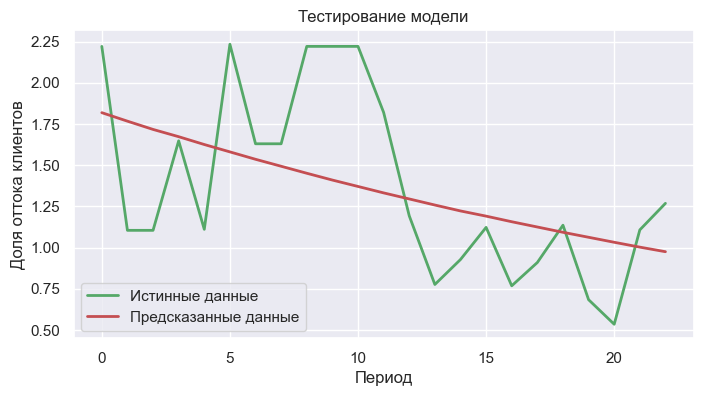

In [44]:
plt.figure(figsize=(8, 4))
plt.plot(df.y, "g", label="true", linewidth=2.0)
pred1 = model.predict(df)
pred1.index = df.index

plt.title('Тестирование модели')
plt.xlabel("Период")
plt.ylabel("Доля оттока клиентов")
plt.plot(pred1.yhat, "r", label="prediction", linewidth=2.0)
plt.legend(["Истинные данные", "Предсказанные данные"], loc ="lower left")

In [ ]:
model.plot(pred, figsize=(8, 4));

In [ ]:
model.plot_components(pred, figsize=(8, 4));